## Explatory Data Analysis (EDA)
This notebook contains the Exploratory Data Analysis for the project, starting from the Trentino database, created by G. Barlacchi and presented in this [paper](https://www.nature.com/articles/sdata201555). The data analysed is social (Twitter), weather (precipitations, temperature, wind) and electrical.

First, let's import some useful libraries.

In [48]:
import json
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

Initially, we consider only the Twitter and weather data. So, let's load the data contained in the files `meteotrentino-weather-station-data.json` and `social-pulse-trentino.geojson`:

In [49]:
with open('../data/raw/meteotrentino-weather-station-data.json') as json_file:
    data_weather = json.load(json_file)
with open('../data/raw/social-pulse-trentino.geojson') as json_file:
    data_twitter = json.load(json_file)

It is necessary to import also the Trentino geojson grid:

In [50]:
grid_path = '../data/raw/trentino-grid.geojson'
df_grid = gpd.read_file(grid_path)

Now, from the json files, we extract only the features (they contain also metadata):

In [51]:
twitter_features = gpd.GeoDataFrame(data_twitter['features'])
weather_features = gpd.GeoDataFrame(data_weather['features'])

They look something like this:

In [52]:
twitter_features.head()

,created,timestamp,user,geomPoint.geom,municipality.name,municipality.acheneID,language,entities
0,2013-11-01T00:04:16,1383260656,5fd4f31f75,"{'type': 'Point', 'coordinates': [11.13, 46.07]}",Trento,http://dandelion.eu/resource/05a192433bede90cd...,it,[]
1,2013-11-01T00:01:14,1383260474,68c0e98182,"{'type': 'Point', 'coordinates': [10.83, 46.23]}",Pinzolo,http://dandelion.eu/resource/96e35a90e246ca017...,tl,[http://it.dbpedia.org/resource/Madonna_di_Cam...
2,2013-11-01T00:43:03,1383262983,abe21fc052,"{'type': 'Point', 'coordinates': [11.46, 46.29]}",Cavalese,http://dandelion.eu/resource/01f847397f180d6c0...,en,"[http://dbpedia.org/resource/Coven, http://dbp..."
3,2013-11-01T00:38:37,1383262717,94d1efbbfd,"{'type': 'Point', 'coordinates': [11.04, 45.89]}",Rovereto,http://dandelion.eu/resource/1841c30a560050875...,it,[]
4,2013-11-01T00:45:40,1383263140,d261d03075,"{'type': 'Point', 'coordinates': [11.12, 46.2]}",San Michele all'Adige,http://dandelion.eu/resource/32ca86fe3c8f5988a...,ru,[http://it.dbpedia.org/resource/Rotari]


In [53]:
weather_features.head()

,station,geomPoint.geom,elevation,date,timestamp,minTemperature,maxTemperature,precipitation,minWind,maxWind,...,winds.2130,winds.2145,winds.2200,winds.2215,winds.2230,winds.2245,winds.2300,winds.2315,winds.2330,winds.2345
0,T0071,"{'type': 'Point', 'coordinates': [10.79582897,...",905,2013-11-01,1383260400,4.5,12.3,False,0.0,2.5,...,0@183,,0@157,,0.4@228,0.3@248,,0@201,0@199,
1,T0032,"{'type': 'Point', 'coordinates': [11.25371981,...",1155,2013-11-01,1383260400,6.5,10.2,False,NaN,NaN,...,,,,,,,,,,
2,T0096,"{'type': 'Point', 'coordinates': [11.6645808, ...",1205,2013-11-01,1383260400,6.5,11.8,False,NaN,NaN,...,,,,,,,,,,
3,T0074,"{'type': 'Point', 'coordinates': [10.91841055,...",720,2013-11-01,1383260400,6.2,13.6,False,0.0,4.8,...,0.3@198,0.3@196,0.4@236,,0.9@15,0.6@345,1@244,0.5@192,0@157,
4,T0101,"{'type': 'Point', 'coordinates': [11.07973339,...",201,2013-11-01,1383260400,11.1,16.3,False,NaN,NaN,...,,,,,,,,,,


We decide to remove unnecessary features to `twitter_features` (user, municipality ID, language, entities):

In [54]:
twitter_features = twitter_features.drop('entities', axis=1)
twitter_features = twitter_features.drop('municipality.acheneID', axis=1)
twitter_features = twitter_features.drop('language', axis=1)
twitter_features = twitter_features.drop('user', axis=1)

Our goal now is to associate to each tweet its weather data, but there are two problems:
1. weather data is collected every 15 minutes and not every second;
2. weather data is referred to a weather station and not to the specific location of the tweet.


### 15-minutes blocks

Let's solve the first problem by assigning to each tweet its 15-minutes block. We need to split the `created` column into date and time:

In [55]:
twitter_features['date'] = twitter_features['created'].str.split('T').str[0]
twitter_features['time'] = twitter_features['created'].str.split('T').str[1]
twitter_features = twitter_features.drop('created', axis=1)
twitter_features = twitter_features[['date', 'time', 'timestamp', 'geomPoint.geom', 'municipality.name']]

Since we need blocks of 15 minutes, we can ignore seconds:

In [56]:
twitter_features['time'] = twitter_features['time'].str.rsplit(':', n=1).str[0]

For the blocks, it is just a simple integer division, but it is important to write the blocks in the format HHMM, to match the weather data:

In [57]:
minutes = twitter_features['time'].str.rsplit(':', n=1).str[1].astype(int)
minutes = ((minutes//15)*15).astype(str).str.zfill(2)

hours = twitter_features['time'].str.rsplit(':', n=1).str[0]

twitter_features['hour_blocks'] = hours + minutes

In [58]:
twitter_features.head()

,date,time,timestamp,geomPoint.geom,municipality.name,hour_blocks
0,2013-11-01,00:04,1383260656,"{'type': 'Point', 'coordinates': [11.13, 46.07]}",Trento,0000
1,2013-11-01,00:01,1383260474,"{'type': 'Point', 'coordinates': [10.83, 46.23]}",Pinzolo,0000
2,2013-11-01,00:43,1383262983,"{'type': 'Point', 'coordinates': [11.46, 46.29]}",Cavalese,0030
3,2013-11-01,00:38,1383262717,"{'type': 'Point', 'coordinates': [11.04, 45.89]}",Rovereto,0030
4,2013-11-01,00:45,1383263140,"{'type': 'Point', 'coordinates': [11.12, 46.2]}",San Michele all'Adige,0045


### Stations dataframe and geometry

The first problem is now assessed, and we should build a stations dataframe to work with them:

In [59]:
df_stations = weather_features[['station', 'geomPoint.geom']]
df_stations.drop_duplicates(subset='station', keep='first', inplace=True)

For all data, it is necessary to transform the geometry column using the library `shapely.geometry.Point`

In [60]:
df_stations['geometry'] = df_stations['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
df_stations.drop(columns=['geomPoint.geom'],inplace=True)
df_stations = gpd.GeoDataFrame(df_stations, geometry='geometry')

In [61]:
twitter_features['geometry'] = twitter_features['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
twitter_features.drop(columns=['geomPoint.geom'],inplace=True)
twitter_features = gpd.GeoDataFrame(twitter_features, geometry='geometry')

In [62]:
weather_features['geometry'] = weather_features['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
weather_features.drop(columns=['geomPoint.geom'],inplace=True)
weather_features = gpd.GeoDataFrame(weather_features, geometry='geometry')

### Choosing the station

To solve the second problem, we decide to assign to each tweet its nearest station, calculating the distance between the tweet location and the station location.

Since we are on a curved surface, for two points that have:
\begin{align}
    &\Delta \lambda = \lambda_2 - \lambda_1 \quad \text{the difference of longitude} \\
    &\Delta \phi = \phi_2 - \phi_1 \quad \text{the difference of latitude}\ ,
\end{align}
we use the [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula):
\begin{equation}
d = 2r\arcsin{\sqrt{\sin^2\left(\frac{\Delta\phi}{2}\right) + \cos\phi_1 \cos\phi_2 \sin^2\left(\frac{\Delta\lambda}{2}\right)}}
\end{equation}
and we search through each station to find the one with the minimum distance.

We start by defining the Haversine distance function (it returns the distance in km):

In [64]:
def haversine_distance(lat1, lon1, lat2, lon2):    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula    
    dlat = lat2 - lat1[:, np.newaxis]
    dlon = lon2 - lon1[:, np.newaxis]    
    a = np.sin(dlat / 2)**2 + np.cos(lat1[:, np.newaxis]) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Earth's radius in kilometers (6371 km)    
    radius = 6371
    
    return radius * c

And it is now just of matter of computing it for every tweet and station:

In [65]:
twitter_lat = np.array(twitter_features.get_coordinates()['y'])
twitter_lon = np.array(twitter_features.get_coordinates()['x'])
station_lat = np.array(df_stations.get_coordinates()['y'])
station_lon = np.array(df_stations.get_coordinates()['x'])

In [66]:
distances = haversine_distance(twitter_lat, twitter_lon, station_lat, station_lon)

In [67]:
nearest_station_index = np.argmin(distances, axis=1).flatten()

In [68]:
twitter_features['station'] = df_stations['station'].iloc[nearest_station_index].values

In [73]:
twitter_features.head()

,date,time,timestamp,municipality.name,hour_blocks,geometry,station
0,2013-11-01,00:04,1383260656,Trento,0000,POINT (11.13000 46.07000),T0129
1,2013-11-01,00:01,1383260474,Pinzolo,0000,POINT (10.83000 46.23000),T0071
2,2013-11-01,00:43,1383262983,Cavalese,0030,POINT (11.46000 46.29000),T0367
3,2013-11-01,00:38,1383262717,Rovereto,0030,POINT (11.04000 45.89000),T0147
4,2013-11-01,00:45,1383263140,San Michele all'Adige,0045,POINT (11.12000 46.20000),T0408


It is nice to look at a plot of the tweets grouped by station.

<Axes: >

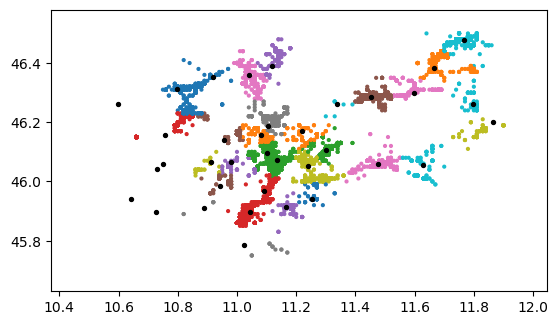

In [87]:
ax = df_grid.plot(color='white')

#twitter_features = gpd.GeoDataFrame(twitter_features)
twitter_features.plot(column='station', ax=ax, cmap='tab10', markersize=4)

#df_stations = gpd.GeoDataFrame(df_stations)
df_stations.plot(ax=ax, color='black', markersize=8)

Now the dataframe `twitter_features` has a `station` column and it can be merged with the `weather_features` dataframe by that column (and by date, since `weather_features` has a date column)!

In [70]:
df = pd.merge(twitter_features, weather_features, on=['station', 'date'], how='left')

In [72]:
df.head()

,date,time,timestamp_x,municipality.name,hour_blocks,geometry_x,station,elevation,timestamp_y,minTemperature,...,winds.2145,winds.2200,winds.2215,winds.2230,winds.2245,winds.2300,winds.2315,winds.2330,winds.2345,geometry_y
0,2013-11-01,00:04,1383260656,Trento,0000,POINT (11.13000 46.07000),T0129,312.0,1.383260e+09,11.7,...,1.4@38,0.8@100,1.1@121,1.5@96,1.4@67,2@86,1.4@79,1.1@70,1.6@59,POINT (11.13565 46.07185)
1,2013-11-01,00:01,1383260474,Pinzolo,0000,POINT (10.83000 46.23000),T0071,905.0,1.383260e+09,4.5,...,,0@157,,0.4@228,0.3@248,,0@201,0@199,,POINT (10.79583 46.31340)
2,2013-11-01,00:43,1383262983,Cavalese,0030,POINT (11.46000 46.29000),T0367,958.0,1.383260e+09,7.0,...,,,,,,0.1@216,0.2@205,,0.6@264,POINT (11.45171 46.28478)
3,2013-11-01,00:38,1383262717,Rovereto,0030,POINT (11.04000 45.89000),T0147,203.0,1.383260e+09,11.0,...,0.8@48,0.8@152,0.5@111,0.8@13,0.5@164,0.9@132,1.5@137,0.7@3,0.9@359,POINT (11.04379 45.89644)
4,2013-11-01,00:45,1383263140,San Michele all'Adige,0045,POINT (11.12000 46.20000),T0408,204.0,1.383260e+09,9.6,...,,,,,,,,,,POINT (11.10461 46.18723)


It is noticeable that after the merge some columns are named with a `_x` or `_y`suffix. That's because they have the same name in the parents dataframes but we do not merge by those. We decide to remove from `df` the columns corresponding to the location of the station and the timestamp of the station.

In [75]:
df = df.drop(['timestamp_y', 'geometry_y'], axis=1)

Lastly (just for this first merge, don't worry), we need to select the right temperature, precipitation and wind values to keep in the dataframe, since we just need those that match the 15-minutes blocks of the tweets.

In [79]:
def get_temperature(row):
    str = 'temperatures.' + row['hour_blocks']
    return row[str]
df['temperature'] = df.apply(get_temperature, axis=1)

In [80]:
def get_precipitation(row):
    str = 'precipitations.' + row['hour_blocks']
    return row[str]
df['precipitation'] = df.apply(get_precipitation, axis=1)

In [81]:
def get_wind(row):
    str = 'winds.' + row['hour_blocks']
    return row[str]
df['wind'] = df.apply(get_wind, axis=1)

And we can drop all the other temperature, precipitation and wind columns:

In [82]:
df = df.drop([col for col in df.columns if col.startswith('temperatures.')], axis=1)
df = df.drop([col for col in df.columns if col.startswith('precipitations.')], axis=1)
df = df.drop([col for col in df.columns if col.startswith('winds.')], axis=1)

In [83]:
df.head()

,date,time,timestamp_x,municipality.name,hour_blocks,geometry_x,station,elevation,minTemperature,maxTemperature,precipitation,minWind,maxWind,temperature,wind
0,2013-11-01,00:04,1383260656,Trento,0000,POINT (11.13000 46.07000),T0129,312.0,11.7,16.0,0.0,0.2,2.0,13.2,1@47
1,2013-11-01,00:01,1383260474,Pinzolo,0000,POINT (10.83000 46.23000),T0071,905.0,4.5,12.3,0.0,0.0,2.5,8.4,0.1@205
2,2013-11-01,00:43,1383262983,Cavalese,0030,POINT (11.46000 46.29000),T0367,958.0,7.0,13.0,0.0,0.0,1.8,8.8,
3,2013-11-01,00:38,1383262717,Rovereto,0030,POINT (11.04000 45.89000),T0147,203.0,11.0,18.4,0.0,0.2,1.9,13.2,0.6@7
4,2013-11-01,00:45,1383263140,San Michele all'Adige,0045,POINT (11.12000 46.20000),T0408,204.0,9.6,16.9,0.0,NaN,NaN,11.6,


At this point, Twitter and weather data are merged. Let's move on to electrical data.